In [13]:
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
#import statannotations
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import multipletests
import math
import os
#pip install --upgrade seaborn==0.11.2
#REQUIERD VERSION 0.11.2

# Functions

In [2]:
def FAindex6(rightMeasurements, leftMeasurements):
    # Based on: https://www.annualreviews.org/doi/pdf/10.1146/annurev.es.17.110186.002135
    # Page 395, table 1
    areaNormalized = rightMeasurements;
    
    for numMeas in range(len(rightMeasurements)):
        a_i = rightMeasurements[numMeas] - leftMeasurements[numMeas];
        avg = (rightMeasurements[numMeas] + leftMeasurements[numMeas])/2;
        areaNormalized[numMeas] = a_i / avg;
        
    res = np.var(areaNormalized)
    return [res, areaNormalized]
    

# Defining initial conditions

In [4]:
# Defining initial folders
whoIsRunning = 'Jan'

if whoIsRunning == 'Jan':
    conditionsFolder = ['1g', "5RPM", '33RPM']
    conditions = ['Still', "5RPM", '33RPM']
    sexes = {'Females', 'Males', ''}
    typesOfAnalysis = {'Output_area.dat', 'Output_vLength.dat', 'Output_Landmarks.dat'}


features = {'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', \
            'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', \
           'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', \
            'A4_A5', 'A1_A2_A3', 'A6_A7', \
           'L9_L10_L11', 'L7_L8', 'L12_L13', \
           'wingWidth'}

In [6]:
outputFolder = 'Results2'
#if not os.path.exists(outputFolder):
 #   os.makedirs(outputFolder)

## Loading data

In [7]:
data = []
for numCondition in range(len(conditionsFolder)):
    dataCondition = []
    for typeOfAnalysis in typesOfAnalysis:
        filepath = conditionsFolder[numCondition]+'/'+typeOfAnalysis
        print(filepath)
        new_df = pd.read_csv(filepath,sep='\t')
        new_df['condition'] = conditions[numCondition]
        dataCondition.append(new_df)

    dfCondition = pd.concat(dataCondition, axis=1);
    dfCondition = dfCondition.T.drop_duplicates().T;
    data.append(dfCondition)

df_analysis = pd.concat(data);

1g/Output_area.dat
1g/Output_vLength.dat
1g/Output_Landmarks.dat
5RPM/Output_area.dat
5RPM/Output_vLength.dat
5RPM/Output_Landmarks.dat
33RPM/Output_area.dat
33RPM/Output_vLength.dat
33RPM/Output_Landmarks.dat


## Compute measurements

### Compute new measurements

In [8]:
# Width of wing
distance2Points = (df_analysis['x1'] - df_analysis['x4'])**2 + (df_analysis['y1'] - df_analysis['y4'])**2
wingWidth = distance2Points.apply(lambda x: math.sqrt(x))
df_analysis['wingWidth'] = wingWidth

In [11]:
results = [];
individualResults = [];
for numCondition in range(len(conditions)):
    condition = conditions[numCondition]
    
    for sex in sexes:
        generalCondition = np.array(df_analysis['condition'] == condition);

        if np.array(df_analysis['CPFile'].str.contains('_Females_')).any():
            if sex == '':
                generalCondition = generalCondition & np.array(df_analysis['CPFile'].str.contains(''))
            else:
                generalCondition = generalCondition & np.array(df_analysis['CPFile'].str.contains('_'+sex+'_'))
            
        else:
            generalCondition = generalCondition & np.array(df_analysis['Sex'].str.contains(sex))

        rightWings = df_analysis[np.array(df_analysis['Tags'].str.contains('right')) & generalCondition]
        leftWings = df_analysis[np.array(df_analysis['Tags'].str.contains('left')) & generalCondition]
        
        # Measures normalised by area of the wing
        if sex != '':
            conditionsRepeated_left = np.matlib.repmat([condition, sex, 'left'], leftWings.shape[0], 1)
            conditionsRepeated_right = np.matlib.repmat([condition, sex, 'right'], rightWings.shape[0], 1)
        else:
            conditionsRepeated_left = np.matlib.repmat([condition, 'All', 'left'], leftWings.shape[0], 1)
            conditionsRepeated_right = np.matlib.repmat([condition, 'All', 'right'], rightWings.shape[0], 1)
            
        for feature in features:
            if feature in leftWings.columns:
                wingValues_left = np.array(100*leftWings[feature]/leftWings['AWing']);
                wingValues_right = np.array(100*rightWings[feature]/rightWings['AWing']);
            else:
                addFeatures = feature.split('_')
                addingFeatures = leftWings[addFeatures]
                wingValues_left = np.array(100*addingFeatures.sum(axis=1)/leftWings['AWing']);
                addingFeatures = rightWings[addFeatures]
                wingValues_right = np.array(100*addingFeatures.sum(axis=1)/rightWings['AWing']);
                
            conditionsRepeated_left = np.column_stack((conditionsRepeated_left, wingValues_left))
            conditionsRepeated_right = np.column_stack((conditionsRepeated_right, wingValues_right))

        conditionsRepeated_left = np.column_stack((conditionsRepeated_left, leftWings['AWing']))
        conditionsRepeated_right = np.column_stack((conditionsRepeated_right, rightWings['AWing']))
            
        columnNames = np.append(['condition', 'Sex', 'side'], numpy.array(list(features)))
        columnNames = np.append(columnNames, ['AWing'])
        
        newIndividualResults_left = pd.DataFrame(conditionsRepeated_left, columns=columnNames)
        newIndividualResults_right = pd.DataFrame(conditionsRepeated_right, columns=columnNames)
        individualResults.append(newIndividualResults_left)
        individualResults.append(newIndividualResults_right)
        
        # Save results into a DF
        newResult_df = pd.DataFrame([[condition, sex, sum(generalCondition)/2]], \
                       columns=['condition', 'Sex', 'n'])
        results.append(newResult_df)

individualResults_df = pd.concat(individualResults)
results_df = pd.concat(results)

features_array = np.array(list(features))
features_array = np.append(features_array, 'AWing')
individualResults_df[features_array] = individualResults_df[features_array].apply(pd.to_numeric)

In [ ]:
# Sort to show them in the correct order
#individualResults_df = individualResults_df.sort_values(by=['Sex'])

## Wing features from Wings4 normalised by its total wing area

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Still vs. 5RPM: Custom statistical test, P_val:1.494e-03
5RPM vs. 33RPM: Custom statistical test, P_val:3.146e-02
Still vs. 33RPM: Custom statistical test, P_val:1.000e+00


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jan\\OneDrive\\Documents\\UCL\\dissertation\\Results2\\wingFeatures_L12.png'

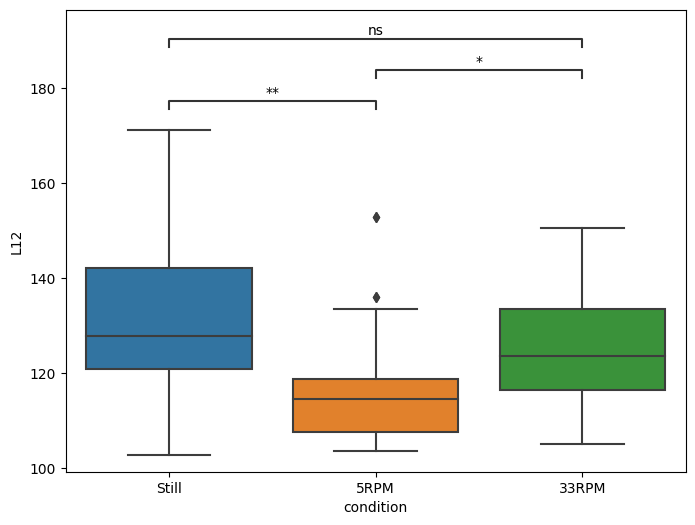

In [14]:
pairs = [(conditions[0], conditions[1]), (conditions[0], conditions[2]), (conditions[1], conditions[2])]

# Store all p-values for multiple testing correction
all_p_values = []

# First, calculate p-values for all features
for feature in features_array:
    for cond1, cond2 in pairs:
        group1 = individualResults_df[individualResults_df["condition"] == cond1][feature]
        group2 = individualResults_df[individualResults_df["condition"] == cond2][feature]
        _, p = ttest_ind(group1, group2)
        all_p_values.append(p)

# Apply Bonferroni correction
corrected_pvals = multipletests(all_p_values, method='bonferroni')[1]

# Loop through each feature and generate plots
for numAxs, feature in enumerate(features_array):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Boxplot
    sns.boxplot(data=individualResults_df, x="condition", y=feature, order=conditions, ax=ax)

    # Initialize annotator for p-values
    annotator = Annotator(ax, pairs, data=individualResults_df, x="condition", y=feature, order=conditions)
    
    # Extract the corrected p-values for this feature
    feature_pvals = corrected_pvals[numAxs * len(pairs):(numAxs + 1) * len(pairs)]
    
    # Set and display annotations
    annotator.set_pvalues(feature_pvals).annotate()

    # Save the annotated boxplot
    fig.savefig(outputFolder + f'/wingFeatures_{feature}.png', dpi=300, bbox_inches='tight')

    # Swarm plot
    fig, ax = plt.subplots(figsize=(8, 6)) 
    sns.stripplot(data=individualResults_df, x="condition", y=feature, order=conditions, dodge=True, ax=ax)

    # Save the swarm plot
    #fig.savefig(outputFolder + f'/wingFeatures_swarm_{feature}.png', dpi=300, bbox_inches='tight')

plt.show()